# 🚌 datac / 📈 analysis

In [1]:
import pytz
import pandas
from datetime import datetime, timedelta

import gtfs_kit as gk
import matplotlib.pyplot as plt

In [2]:
DATE = datetime(2024, 3, 20, tzinfo=pytz.timezone("Europe/Rome"))

In [3]:
vehicle_positions = pandas.read_parquet("../downloads/vehicle_positions.parquet")
vehicle_positions = vehicle_positions[vehicle_positions["vehicle.trip.start_date"].dt.date == DATE.date()]
vehicle_positions = vehicle_positions.sort_values(by=["vehicle.trip.trip_id", "vehicle.timestamp"]).reset_index(
    drop=True
)

## Routes

### Number of monitored routes

In [4]:
monitored_route_ids = vehicle_positions["vehicle.trip.route_id"].unique()
len(monitored_route_ids)

375

### Read planning

In [5]:
feed = gk.read_feed("../downloads/schedule_updates/2024-03-20T06_34_14.zip", dist_units="km")

### Number of planned routes

In [6]:
routes = feed.get_routes(date=DATE.strftime("%Y%m%d"))
route_ids = routes["route_id"].unique()
len(route_ids)

399

In [7]:
unimonitored_route_ids = set(route_ids) - set(monitored_route_ids)

### % of monitored routes

In [8]:
NUM_METRO_LINES = 4

round(len(monitored_route_ids) / (len(route_ids) - NUM_METRO_LINES) * 100, 1)

94.9

### Unmonitored routes

In [9]:
routes[routes["route_id"].isin(unimonitored_route_ids)][["route_short_name", "route_long_name", "route_url"]]

,route_short_name,route_long_name,route_url
11,551,<NA>,https://muoversiaroma.it/it/linea?numero=551
28,500,<NA>,https://muoversiaroma.it/it/linea?numero=500
55,246,<NA>,https://muoversiaroma.it/it/linea?numero=246
58,021,<NA>,https://muoversiaroma.it/it/linea?numero=021
236,043,<NA>,https://muoversiaroma.it/it/linea?numero=043
242,113,<NA>,https://muoversiaroma.it/it/linea?numero=113
244,246P,<NA>,https://muoversiaroma.it/it/linea?numero=246P
246,351,<NA>,https://muoversiaroma.it/it/linea?numero=351
254,319,<NA>,https://muoversiaroma.it/it/linea?numero=319
269,718,<NA>,https://muoversiaroma.it/it/linea?numero=718


## Trips

In [10]:
planned_trips = feed.get_trips(date=DATE.strftime("%Y%m%d"))

### % of monitored trips

In [11]:
recorded_trips_ids = vehicle_positions["vehicle.trip.trip_id"].unique()
planned_trip_ids = planned_trips["trip_id"].unique()
assert len(set(recorded_trips_ids) - set(planned_trip_ids)) < 100  # sanity check

round(recorded_trips_ids.size / planned_trip_ids.size * 100, 2)

77.93

### % of monitored trips (excluding unmonitored routes)

In [12]:
planned_trip_ids_excl_unmonitored_routes = planned_trips["trip_id"][
    ~planned_trips["route_id"].isin(unimonitored_route_ids)
].unique()

round(recorded_trips_ids.size / planned_trip_ids_excl_unmonitored_routes.size * 100, 2)

84.75

## Route Analysis

In [ ]:
vehicle_positions = vehicle_positions[
    ~(
        (
            (vehicle_positions["vehicle.position.odometer"] == 0.0)
            & (vehicle_positions["vehicle.current_stop_sequence"] != 1)
        )  # fixes some weird occurences where the odometer drops to 0 in the middle of the trip
        | (
            (vehicle_positions["vehicle.position.odometer"] > 50.0)
            & (vehicle_positions["vehicle.current_stop_sequence"] == 1)
        )
    )
]
len(vehicle_positions)

In [ ]:
emitted_positions_count_by_route = vehicle_positions["vehicle.trip.route_id"].value_counts()
vehicle_positions = vehicle_positions[
    vehicle_positions["vehicle.trip.route_id"].isin(
        emitted_positions_count_by_route[emitted_positions_count_by_route > 3500].index
    )  # limits the analysis to routes that emit at least 3500 events per day
]
len(vehicle_positions)

In [ ]:
def compute_commercial_speed_per_route_and_trip(
    vehicle_positions: pandas.DataFrame,
    min_speed_cutoff: float = 0.0,
    max_speed_cutoff: float = 35.0,
) -> pandas.DataFrame:
    relevant_cols = [
        "vehicle.trip.route_id",
        "vehicle.trip.trip_id",
        "vehicle.timestamp",
        "vehicle.position.odometer",
        "vehicle.current_stop_sequence",
    ]
    relevant_view = vehicle_positions[relevant_cols]

    odometer_and_timestamp_minmax = relevant_view.groupby(
        ["vehicle.trip.route_id", "vehicle.trip.trip_id"], observed=False
    ).agg({"vehicle.timestamp": ["min", "max", "mean"], "vehicle.position.odometer": ["min", "max"]})

    trips = (
        (
            (
                (
                    odometer_and_timestamp_minmax["vehicle.position.odometer"]["max"]
                    - odometer_and_timestamp_minmax["vehicle.position.odometer"]["min"]
                )
                / 1000  # km
            )
            / (
                (
                    odometer_and_timestamp_minmax["vehicle.timestamp"]["max"]
                    - odometer_and_timestamp_minmax["vehicle.timestamp"]["min"]
                ).dt.seconds
                / 3600  # hours
            )
        )
        .rename("vehicle.commercial_speed_kmh")
        .to_frame()
        .assign(**{"vehicle.timestamp.mean": odometer_and_timestamp_minmax["vehicle.timestamp"]["mean"]})
    )

    return trips[
        (min_speed_cutoff < trips["vehicle.commercial_speed_kmh"])
        & (trips["vehicle.commercial_speed_kmh"] < max_speed_cutoff)
    ]

In [6]:
trips = compute_commercial_speed_per_route_and_trip(vehicle_positions)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/fra/.cache/pypoetry/virtualenvs/datac-analysis-5tLNiopQ-py3.13/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36497/796451707.py", line 1, in <module>
    trips = compute_commercial_speed_per_route_and_trip(vehicle_positions)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'compute_commercial_speed_per_route_and_trip' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/fra/.cache/pypoetry/virtualenvs/datac-analysis-5tLNiopQ-py3.13/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "/home/fra/.cache/pypoetry/virtualenv

In [16]:
trips[["vehicle.commercial_speed_kmh"]].describe()

,vehicle.commercial_speed_kmh
count,14202.000000
mean,12.329209
std,6.424385
min,0.000933
25%,8.121528
50%,12.221031
75%,16.138639
max,34.978412


In [17]:
trips[["vehicle.commercial_speed_kmh"]].groupby(level=0, observed=False).mean().dropna().sort_values(
    by="vehicle.commercial_speed_kmh"
).round(2)

,vehicle.commercial_speed_kmh
vehicle.trip.route_id,
64,3.10
492,3.38
62,3.50
51,3.50
46,3.52
...,...
508,20.47
04,20.49
075,20.51


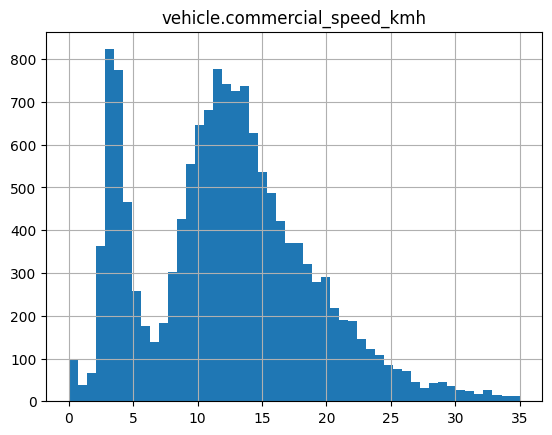

In [20]:
trips[["vehicle.commercial_speed_kmh"]].hist(bins=50)
plt.show()

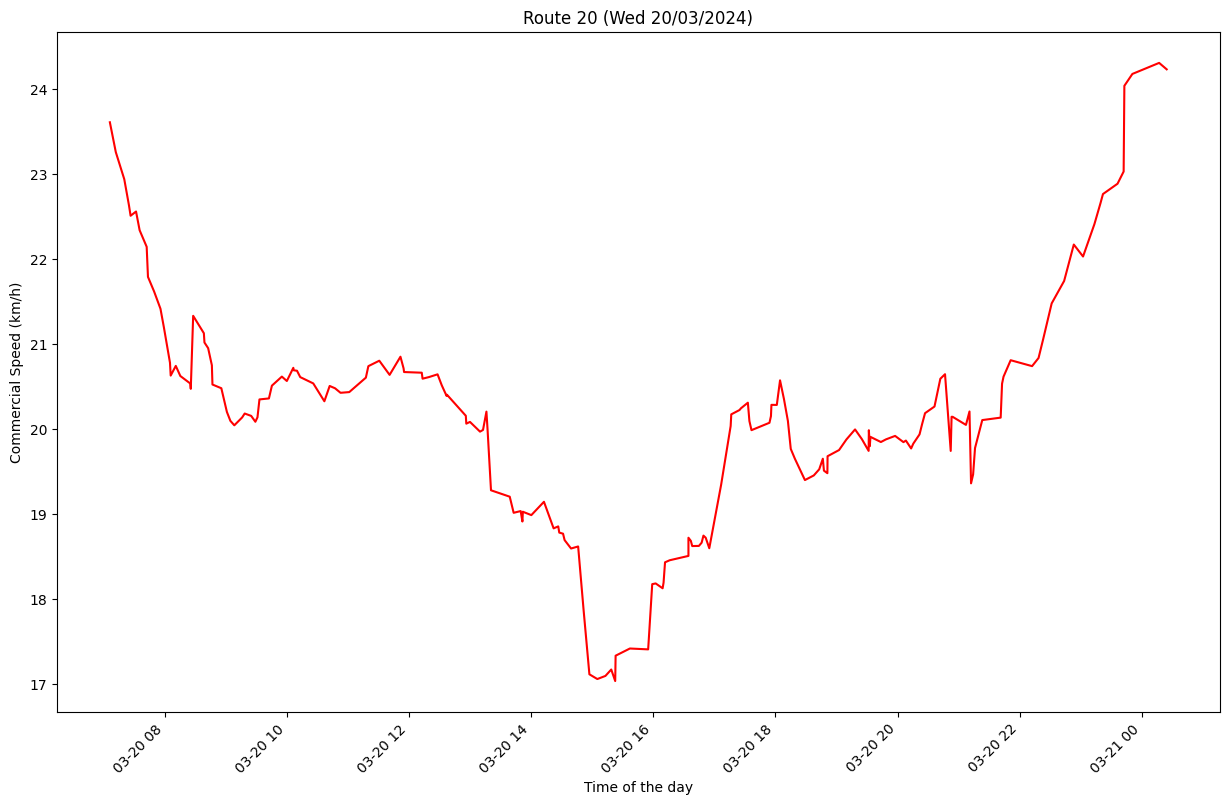

In [21]:
ROUTE_ID = "20"

(
    trips.loc[ROUTE_ID]
    .set_index("vehicle.timestamp.mean")
    .sort_index()
    .interpolate()
    .rolling(25)
    .mean()
    .plot(
        rot=45,
        title=f"Route {ROUTE_ID} (Wed 20/03/2024)",
        ylabel="Commercial Speed (km/h)",
        xlabel="Time of the day",
        legend=False,
        figsize=(15, 10),
        color="red",
    )
)
plt.show()

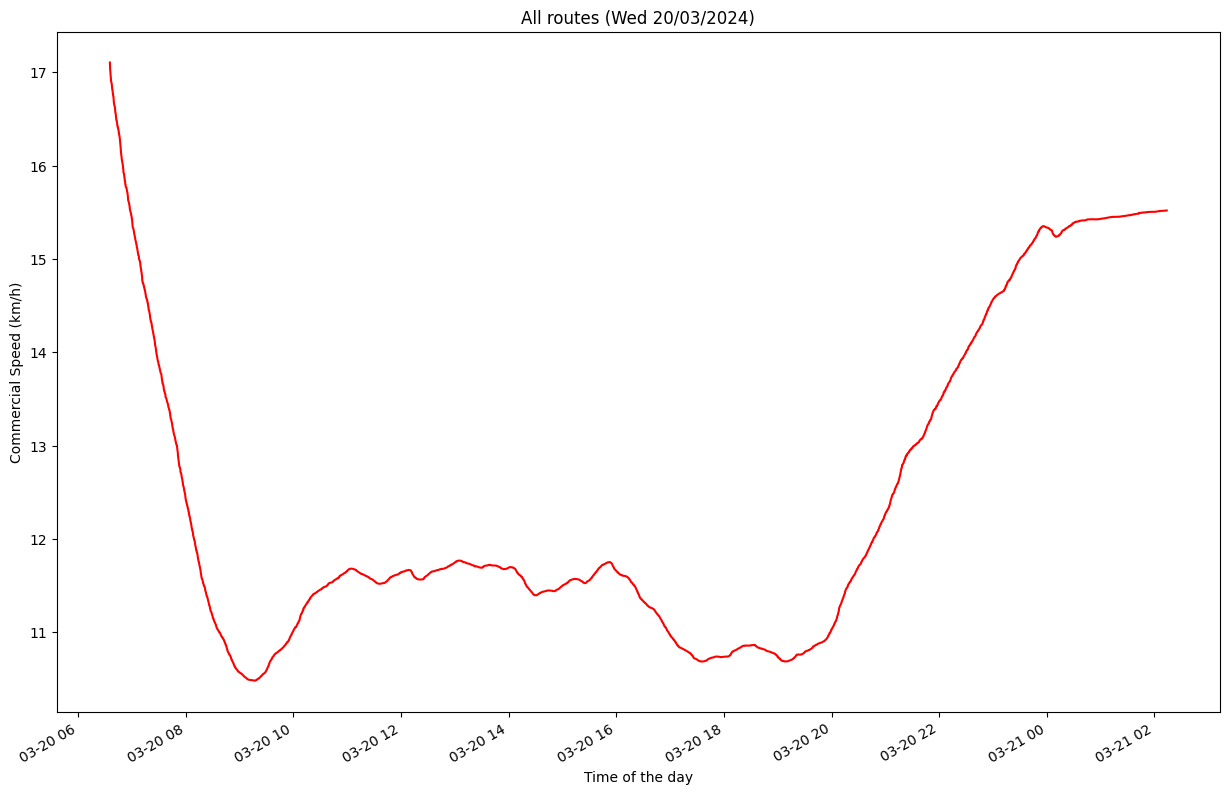

In [23]:
(
    trips.set_index("vehicle.timestamp.mean")
    .sort_index()
    .rolling(timedelta(minutes=15), min_periods=2)
    .mean()
    .rolling(1000)
    .mean()
    .plot(
        title="All routes (Wed 20/03/2024)",
        figsize=(15, 10),
        xlabel="Time of the day",
        ylabel="Commercial Speed (km/h)",
        legend=False,
        color="red",
    )
)

plt.show()

## Travel Speed by Area

In [13]:
def compute_travel_speed_by_area(vehicle_positions: pandas.DataFrame):
    relevant_cols = [
        "vehicle.trip.trip_id",
        "vehicle.timestamp",
        "vehicle.position.odometer",
        "vehicle.current_status",
        "vehicle.position.latitude",
        "vehicle.position.longitude",
    ]
    moving_vehicle_positions = vehicle_positions[relevant_cols]
    moving_vehicle_positions = moving_vehicle_positions[moving_vehicle_positions["vehicle.current_status"] != 1]
    moving_vehicle_positions["speed"] = (
        moving_vehicle_positions.groupby("vehicle.trip.trip_id")["vehicle.position.odometer"].diff() / 1000
    ) / (moving_vehicle_positions.groupby("vehicle.trip.trip_id")["vehicle.timestamp"].diff().dt.total_seconds() / 3600)
    return (
        moving_vehicle_positions[(moving_vehicle_positions["speed"] > 0.0) & (moving_vehicle_positions["speed"] < 50.0)].dropna(subset="speed").reset_index(drop=True)
    )

In [14]:
travel_speed = compute_travel_speed_by_area(vehicle_positions)

In [15]:
travel_speed

,vehicle.trip.trip_id,vehicle.timestamp,vehicle.position.odometer,vehicle.current_status,vehicle.position.latitude,vehicle.position.longitude,speed
0,0#1000-10,2024-03-20 10:01:30+01:00,1106.0,2,41.862171,12.627262,35.200000
1,0#1000-10,2024-03-20 10:02:16+01:00,1637.0,2,41.857853,12.626041,41.556522
2,0#1000-10,2024-03-20 10:02:46+01:00,1891.0,2,41.856205,12.625250,30.480000
3,0#1000-10,2024-03-20 10:04:18+01:00,2405.0,2,41.858559,12.630112,20.113043
4,0#1000-10,2024-03-20 10:04:48+01:00,2471.0,2,41.859138,12.630471,7.920000
...,...,...,...,...,...,...,...
626104,0#978-7,2024-03-20 19:21:14+01:00,1180.0,2,41.838150,12.596352,42.730435
626105,0#978-7,2024-03-20 19:22:30+01:00,1539.0,2,41.836609,12.600357,17.005263
626106,0#978-7,2024-03-20 19:23:16+01:00,1687.0,2,41.836067,12.601771,11.582609
626107,0#978-7,2024-03-20 19:25:18+01:00,2197.0,2,41.833950,12.607442,15.049180


In [16]:
import geopandas

In [17]:
travel_speed_gdf = geopandas.GeoDataFrame(
    travel_speed[["vehicle.timestamp", "speed"]],
    geometry=geopandas.points_from_xy(
        travel_speed["vehicle.position.longitude"], travel_speed["vehicle.position.latitude"]
    ),
    crs="EPSG:4326",
).sort_values("vehicle.timestamp").reset_index(drop=True)

In [19]:
import folium

In [21]:
travel_speed_gdf["vehicle.timestamp"] = travel_speed_gdf["vehicle.timestamp"].dt.floor('min')

In [22]:
travel_speed_gdf

,vehicle.timestamp,speed,geometry
0,2024-03-20 03:36:00+01:00,23.290909,POINT (12.55453 41.86103)
1,2024-03-20 03:37:00+01:00,41.791304,POINT (12.55966 41.8582)
2,2024-03-20 03:38:00+01:00,42.876923,POINT (12.56863 41.85315)
3,2024-03-20 03:39:00+01:00,19.683871,POINT (12.5716 41.85111)
4,2024-03-20 03:39:00+01:00,36.805263,POINT (12.57319 41.88396)
...,...,...,...
626104,2024-03-21 02:58:00+01:00,40.015385,POINT (12.56178 41.89184)
626105,2024-03-21 02:58:00+01:00,22.594737,POINT (12.48073 41.8907)
626106,2024-03-21 02:58:00+01:00,23.305263,POINT (12.47396 41.89837)
626107,2024-03-21 02:58:00+01:00,13.878947,POINT (12.48259 41.89651)


In [23]:
travel_speed_gdf = travel_speed_gdf.rename(columns={"speed": "Speed (km/h)"})

In [24]:
unique_ts = travel_speed_gdf["vehicle.timestamp"].unique()

In [25]:
unique_ts

<DatetimeArray>
['2024-03-20 03:36:00+01:00', '2024-03-20 03:37:00+01:00',
 '2024-03-20 03:38:00+01:00', '2024-03-20 03:39:00+01:00',
 '2024-03-20 03:40:00+01:00', '2024-03-20 03:41:00+01:00',
 '2024-03-20 03:42:00+01:00', '2024-03-20 03:43:00+01:00',
 '2024-03-20 03:45:00+01:00', '2024-03-20 03:47:00+01:00',
 ...
 '2024-03-21 02:49:00+01:00', '2024-03-21 02:50:00+01:00',
 '2024-03-21 02:51:00+01:00', '2024-03-21 02:52:00+01:00',
 '2024-03-21 02:53:00+01:00', '2024-03-21 02:54:00+01:00',
 '2024-03-21 02:55:00+01:00', '2024-03-21 02:56:00+01:00',
 '2024-03-21 02:57:00+01:00', '2024-03-21 02:58:00+01:00']
Length: 1396, dtype: datetime64[ns, Europe/Rome]

In [58]:
idx = 750
plot = travel_speed_gdf[travel_speed_gdf["vehicle.timestamp"] == unique_ts[idx]].explore("Speed (km/h)", tiles="Cartodb Positron", cmap="RdYlGn")
plot.get_root().html.add_child(folium.Element(f'<h1 style="position:absolute;z-index:100000;left:20vw" >{unique_ts[idx]}</h1>'))
plot